In [1]:
using PyPlot
versioninfo()

Julia Version 0.6.2
Commit d386e40c17* (2017-12-13 18:08 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


# Overview

[Numerical Continuation](https://en.wikipedia.org/wiki/Numerical_continuation) is a set of methods to calculate approximate solutions to equations of the form

$$ F(\mathbf{u}) = 0 \quad F: \mathbb{R}^{N+1} \rightarrow \mathbb{R}^{N} $$

Applications of continuation methods range from dynamical systems to homotopy methods for polynomials (for the latter, the Julia package [HomotopyContinuation.jl](http://pkg.julialang.org/detail/HomotopyContinuation) exists). The state-of-the-art software for numerical continuation is the Fortran package [AUTO](https://sourceforge.net/projects/auto-07p/) and the python package [PyCont](http://www2.gsu.edu/~matrhc/PyCont.html).

This notebook includes a rudimentary implementation of the traditional predictor-corrector continuation method. Compared to more sophisticated methods in AUTO and PyCont, what our method lacks is the ability to adapt the step length and numerically approximate the Jacobian of $F$. The interface for the methods are in part inspired by [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/index.html).

For an in-depth review of different numerical continuation methods, you can refer to the book: Allgower, Eugene L., and Kurt Georg. Introduction to numerical continuation methods. Vol. 45. SIAM, 2003.

In [33]:
struct Tracer
    F! # F!(Fu, Ju, u) computes F and its Jacobian in-place

    # The "state" of the tracer (where it is currently at)
    u::Vector{Float64}
    Fu::Vector{Float64}
    Ju::Matrix{Float64}

    # Options and parameters
    stepsize::Float64 # step size for the predictor
    tol::Float64 # tolerance for the corrector
    direction::Int # +1/-1 for positive/negative orientation
end

"""
    Tracer(F!, u0; kwargs...) -> t

Constructor for `Tracer` given the function `F!` and initial guess `u0`.

`F!` has the signature `F!(Fu, Ju, u)`, which computes the value of the function `Fu` and its 
 Jacobian `Ju` at point `u` in place. `u0` should be moderately close to the solution curve but 
 in general need not satisfy the residual tolerance. 

Keyword arguments:

* stepsize (default: 0.01): the fixed step size used in the predictor step.

* tol (default: 1e-6): the tolerance in residual used in the corrector step.

* direction (default: 1): the direction in which the tracer moves. Can be +1 or -1.
"""
function Tracer(F!, u0::Vector{Float64}; stepsize=0.2, tol=1e-6, direction=1)
    @assert stepsize > 0
    @assert tol > 0
    @assert direction in (1, -1)
    
    # Compute Fu and Ju for initial guess
    N = length(u0) - 1
    Fu0 = Vector{Float64}(N)
    Ju0 = Matrix{Float64}(N, N+1)
    F!(Fu0, Ju0, u0)
    t0 = Tracer(F!, u0, Fu0, Ju0, stepsize, tol, direction)
    
    # Perform a corrector step to have an initial point within residual tolerance
    correct!(t0)
    return t0
end

"""
    move!(t, du)

Advance the tracer by displacement `du` and recomputes `t.Fu` and `t.Ju`.
"""
function move!(t::Tracer, du::Vector{Float64})
    t.u .+= du
    t.F!(t.Fu, t.Ju, t.u)
end

"""
    predict!(t)

Performs a prediction step and advance the tracer to the predicted point.
"""
function predict!(t::Tracer)
    # Compute the tangent vector using QR factorization
    # TODO: determine how exactly Julia computes QR (in particular, what is det(Q))
    N = length(t.u) - 1
    fact = qrfact(t.Ju')
    tvec = fact[:Q][:,end] # tvec is a unit tangent vector
    # Point z to the positive orientation
    if (-1)^N * prod(diag(fact[:R])) < 0
        tvec *= -1
    end
    move!(t, t.stepsize * t.direction * tvec)
end

"""
    correct!(t) -> niter

Performs a correction step and returns the number of Newton iterations.

Also used in initialization to obtain the starting point. The output is discarded in this notebook, 
 but it is an important metric used in step size adaptation.
"""
function correct!(t::Tracer)
    niter = 0
    while norm(t.Fu) > t.tol
        move!(t, -t.Ju \ t.Fu) # Newton update
        niter += 1
    end
    return niter
end

step!(t::Tracer) = (predict!(t); correct!(t)) # one predictor-corrector step
;

In [78]:
struct Parabola
    # y^2 = 2px
    p::Float64
end

function (c::Parabola)(Fu, Ju, u)
    Fu[1] = 2 * c.p * u[1] - u[2]^2
    Ju[1,1] = 2 * c.p
    Ju[1,2] = -2 * u[2]
end

struct SerpentineCurve
    # y(x^2 + a^2) = abx
    a::Float64
    b::Float64
end

function (c::SerpentineCurve)(Fu, Ju, u)
    x = u[1]; y = u[2]
    Fu[1] = x^2 * y - c.a * c.b * x + c.a^2 * y
    Ju[1] = 2 * x * y - c.a * c.b
    Ju[2] = x^2 + c.a^2
end

struct DioclesCissoid
    # x(x^2 + y^2) = 2ay^2
    a::Float64
end

function (c::DioclesCissoid)(Fu, Ju, u)
    x = u[1]; y = u[2]
    Fu[1] = x^3 + x * y^2 - 2 * c.a * y^2
    Ju[1] = 3 * x^2 + y^2
    Ju[2] = 2 * (x - 2 * c.a) * y
end

struct MaclaurinTrisectrix
    # y^2(a - x) = x^2(x + 3a)
    a::Float64
end

function (c::MaclaurinTrisectrix)(Fu, Ju, u)
    x = u[1]; y = u[2]
    Fu[1] = x^3 + x * y^2 + 3 * c.a * x^2 - c.a * y^2
    Ju[1,1] = 3 * x^2 + y^2 + 6 * c.a * x
    Ju[1,2] = 2 * x * y - 2 * c.a * y
end

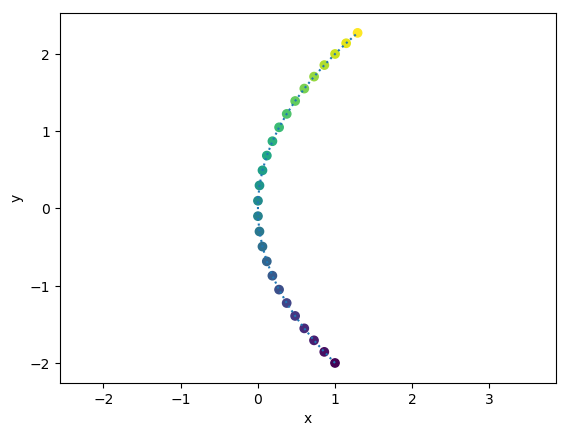

In [77]:
curve = Parabola(2.0)
u0 = [1.0, -2.0]
tracer = Tracer(curve, u0)
Nstep = 25
trajectory = zeros(2,Nstep+1); trajectory[:,1] = tracer.u
for step = 1:Nstep
    step!(tracer)
    trajectory[:,step+1] = tracer.u
end

plot(trajectory[1,:], trajectory[2,:], ":")
scatter(trajectory[1,:], trajectory[2,:], c=1:Nstep+1)
xlabel("x")
ylabel("y")
axis("equal")
;

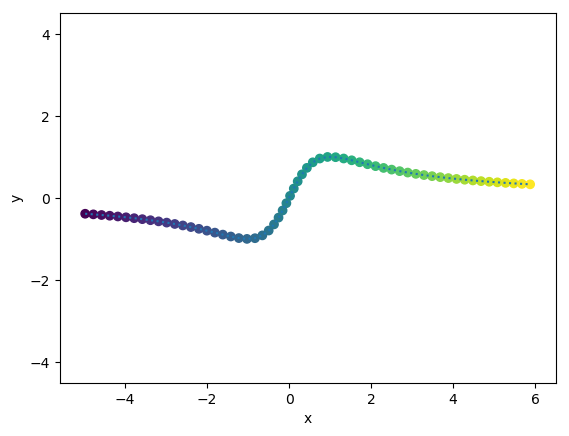

In [76]:
curve = SerpentineCurve(1.0, 2.0)
u0 = [-5.0, 0.0]
tracer = Tracer(curve, u0; direction=-1)
Nstep = 60
trajectory = zeros(2,Nstep+1); trajectory[:,1] = tracer.u
for step = 1:Nstep
    step!(tracer)
    trajectory[:,step+1] = tracer.u
end

plot(trajectory[1,:], trajectory[2,:], ":")
scatter(trajectory[1,:], trajectory[2,:], c=1:Nstep+1)
xlabel("x")
ylabel("y")
axis("equal")
;

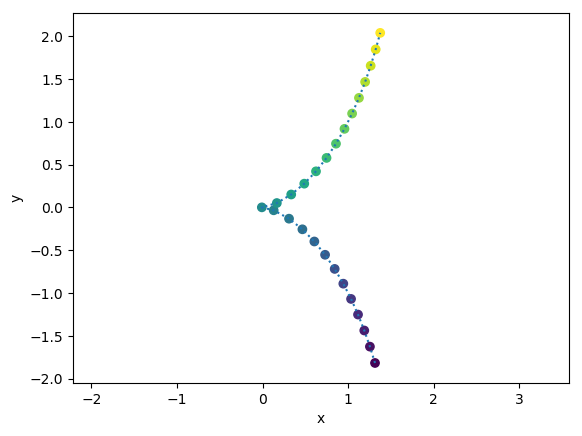

In [75]:
curve = DioclesCissoid(1.0)
u0 = [1.0, -2.0]
tracer = Tracer(curve, u0)
Nstep = 25
trajectory = zeros(2,Nstep+1); trajectory[:,1] = tracer.u
for step = 1:Nstep
    step!(tracer)
    trajectory[:,step+1] = tracer.u
end

plot(trajectory[1,:], trajectory[2,:], ":")
scatter(trajectory[1,:], trajectory[2,:], c=1:Nstep+1)
xlabel("x")
ylabel("y")
axis("equal")
;

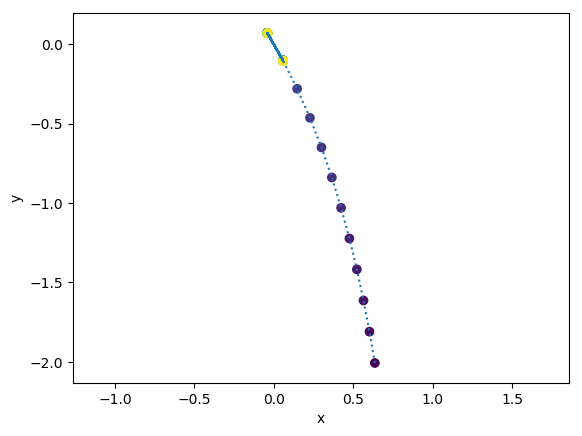

In [84]:
curve = MaclaurinTrisectrix(1.0)
u0 = [1.0, -2.0]
tracer = Tracer(curve, u0)
Nstep = 50
trajectory = zeros(2,Nstep+1); trajectory[:,1] = tracer.u
for step = 1:Nstep
    step!(tracer)
    trajectory[:,step+1] = tracer.u
end

plot(trajectory[1,:], trajectory[2,:], ":")
scatter(trajectory[1,:], trajectory[2,:], c=1:Nstep+1)
xlabel("x")
ylabel("y")
axis("equal")
;